In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

from venn import venn

In [2]:
import pickle

In [32]:
mutect_df = pd.read_csv("../genomic_data/Raw_MuTect2_ALL.csv", sep="\t")
germline_df = pd.read_csv("../genomic_data/Raw_GATK_ALL.csv", sep="\t")
sv_df = pd.read_csv("../genomic_data/Raw_SV_ALL.csv", sep="\t").drop_duplicates()
tert_df = pd.read_csv("../genomic_data/Raw_GATK_MODIFIER_TERT.csv", sep="\t").drop_duplicates()
type_list = {'MUTECT':mutect_df, 'Germline':germline_df, 'SV':sv_df}

In [33]:
samples = pd.read_csv("../../mortal_vs_immortal/SAMPLES/SAMPLES_Excel.tsv", sep="\t")
samples['label'] = samples.apply(lambda x: "T" if x['TMM'] == 'TEL' else "M"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [34]:
samples = samples[samples['Mortal'].str.contains('JFCF')]

In [35]:
gene_list = ['ATRX', 'DAXX', 'TP53']
sample_list = np.concatenate((samples['Immortal'].unique(), samples['Mortal'].unique()))
type_list = {'Somatic':mutect_df, 'Germline':germline_df, 'SV':sv_df}

In [42]:
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))
combined_df_all = pd.concat([mutect_df, germline_df, sv_df, tert_df])

In [43]:
df = combined_df_all[(combined_df_all['Source'] != 'MuTect2') &
                     (combined_df_all['Name'] != 'JFCF_6_P_pLKO_5') &
                     (combined_df_all['Name'] != 'JFCF_6_T_1_P_TEL') &
                     (combined_df_all['Name'].str.contains('JFCF'))].sort_values(
                         by=['Key', 'Name'])
df['Key'] = df['Key'].str.replace('_Immortal', '')
df['Key'] = df['Key'].str.replace('_Somatic', '')
df['Key'] = df['Key'].str.replace('_Mortal', '')
df = df.drop_duplicates(subset=df.columns.values[df.columns.values!='Consequence'])
df = df.drop_duplicates(subset=['Key', 'Name'])

In [45]:
df_TEL = df[df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = df[df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]
df_Mortal = df[df['Name'].isin(samples['Mortal'])]

## TERTp location
Chromosome 5: 1,293,632-1,296,315


## including mortal

In [70]:
df_ALT_TERT_abberations = df_ALT[df_ALT['Gene'] == 'TERT'].groupby(
    ['Key']).size().rename('size').reset_index().sort_values(by=['size','Key'], ascending=[False,True])

In [76]:
df_ALT_TERT_abberations.head()

,Key,size
103,SV_GRIDSS_HIGH_TERT_chr5_1276768_1276771_chr5_...,9
2,IND_GATK_MODIFIER_TERT_chr5_1276769_ACCAATCCCA...,8
17,SNP_GATK_MODIFIER_TERT_chr5_1248354_G_A,8
18,SNP_GATK_MODIFIER_TERT_chr5_1248873_T_A,8
20,SNP_GATK_MODIFIER_TERT_chr5_1250463_T_C,8


In [72]:
df_TEL_TERT_abberations = df_TEL[df_TEL['Gene'] == 'TERT'].groupby(
    ['Key']).size().rename('size').reset_index().sort_values(by=['size','Key'], ascending=[False,True])

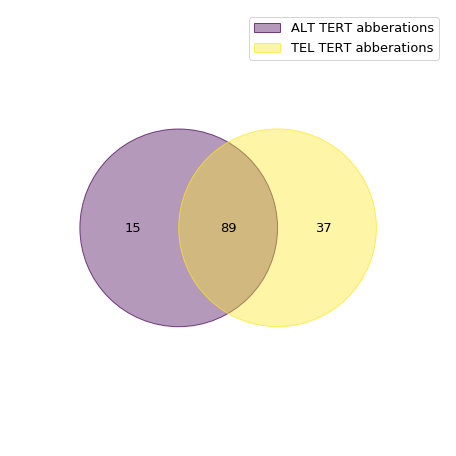

In [96]:
venn_dict = {
    'ALT TERT abberations': set(df_ALT_TERT_abberations['Key']),
    'TEL TERT abberations': set(df_TEL_TERT_abberations['Key'])
}
venn(venn_dict)

In [81]:
df_ALT_TERT_abberations[df_ALT_TERT_abberations['Key'].isin(
    set(df_ALT_TERT_abberations['Key']) - set(df_TEL_TERT_abberations['Key']))].head()

,Key,size
62,SNP_GATK_MODIFIER_TERT_chr5_1284568_C_T,3
9,IND_GATK_MODIFIER_TERT_chr5_1285680_A_ATTTTTTTTT,2
10,IND_GATK_MODIFIER_TERT_chr5_1287611_TC_T,1
12,IND_GATK_MODIFIER_TERT_chr5_1287623_AATAT_A,1
14,IND_GATK_MODIFIER_TERT_chr5_1290510_CTCACCCTGC...,1


In [80]:
df_TEL_TERT_abberations[df_TEL_TERT_abberations['Key'].isin(
    set(df_TEL_TERT_abberations['Key']) - set(df_ALT_TERT_abberations['Key']))].head()

,Key,size
3,IND_GATK_MODIFIER_TERT_chr5_1272735_CA_C,3
2,IND_GATK_MODIFIER_TERT_chr5_1272690_ACATCAGACC...,2
4,IND_GATK_MODIFIER_TERT_chr5_1272738_GACCGCCA_G,2
5,IND_GATK_MODIFIER_TERT_chr5_1272746_TCCACAGTCA...,2
6,IND_GATK_MODIFIER_TERT_chr5_1272768_CCCCA_C,2


## somatic

In [83]:
df_ALT_somatic = df_ALT[~df_ALT['Key'].isin(df_Mortal['Key'])]
df_TEL_somatic = df_TEL[~df_TEL['Key'].isin(df_Mortal['Key'])]

In [84]:
df_ALT_somatic_TERT_abberations = df_ALT_somatic[df_ALT_somatic['Gene'] == 'TERT'].groupby(
    ['Key']).size().rename('size').reset_index().sort_values(by=['size','Key'], ascending=[False,True])
df_ALT_somatic_TERT_abberations.head()

,Key,size
28,SNP_GATK_MODIFIER_TERT_chr5_1287627_T_A,7
6,IND_GATK_MODIFIER_TERT_chr5_1287624_AT_A,6
14,SNP_GATK_MODIFIER_TERT_chr5_1283104_T_C,6
0,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,4
26,SNP_GATK_MODIFIER_TERT_chr5_1285162_C_T,4


In [86]:
df_TEL_somatic_TERT_abberations = df_TEL_somatic[df_TEL_somatic['Gene'] == 'TERT'].groupby(
    ['Key']).size().rename('size').reset_index().sort_values(by=['size','Key'], ascending=[False,True])
df_TEL_somatic_TERT_abberations.head(n=10)

,Key,size
11,IND_GATK_MODIFIER_TERT_chr5_1287624_AT_A,7
17,SNP_GATK_MODIFIER_TERT_chr5_1283104_T_C,7
31,SNP_GATK_MODIFIER_TERT_chr5_1287627_T_A,7
0,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,5
18,SNP_GATK_MODIFIER_TERT_chr5_1283486_T_C,5
30,SNP_GATK_MODIFIER_TERT_chr5_1285162_C_T,5
2,IND_GATK_MODIFIER_TERT_chr5_1272735_CA_C,3
9,IND_GATK_MODIFIER_TERT_chr5_1284535_T_TATCCAGC...,3
15,SNP_GATK_MODIFIER_TERT_chr5_1259604_C_T,3
1,IND_GATK_MODIFIER_TERT_chr5_1272690_ACATCAGACC...,2


In [95]:
df_TEL[df_TEL['Key'].isin(df_TEL_somatic_TERT_abberations.head(n=10)['Key'])]

,Key,Name,Source,dbSNP,Type,Chr1,Pos1,Chr2,Pos2,Qual1,Qual2,AF1,AF2,Read1,Read2,Gene,Consequence,Impact,Ref1,Alt1,Ref2,Alt2
335,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,JFCF_6_T_1J_11C,GATK,True,IND,chr5,1251092,NaN,NaN,220.73,NaN,0.5,NaN,"[7, 15]",NaN,TERT,downstream_gene_variant,MODIFIER,CT,C,NaN,NaN
385,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,JFCF_6_T_1_C,GATK,True,IND,chr5,1251092,NaN,NaN,64.25,NaN,1,NaN,"[1, 5]",NaN,TERT,downstream_gene_variant,MODIFIER,CT,C,NaN,NaN
439,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,JFCF_6_T_1_F,GATK,True,IND,chr5,1251092,NaN,NaN,149.79,NaN,1,NaN,"[1, 9]",NaN,TERT,downstream_gene_variant,MODIFIER,CT,C,NaN,NaN
501,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,JFCF_6_T_1_H,GATK,True,IND,chr5,1251092,NaN,NaN,140.94,NaN,1,NaN,"[2, 9]",NaN,TERT,downstream_gene_variant,MODIFIER,CT,C,NaN,NaN
644,IND_GATK_MODIFIER_TERT_chr5_1251092_CT_C,JFCF_6_T_2H,GATK,True,IND,chr5,1251092,NaN,NaN,83.5,NaN,1,NaN,"[1, 7]",NaN,TERT,downstream_gene_variant,MODIFIER,CT,C,NaN,NaN
746,IND_GATK_MODIFIER_TERT_chr5_1272690_ACATCAGACC...,JFCF_6_T_1J_6B,GATK,False,IND,chr5,1272690,NaN,NaN,215.73,NaN,0.5,NaN,"[13, 7]",NaN,TERT,intron_variant,MODIFIER,ACATCAGACCCTACGACCGCCATCCACAGTCAC,A,NaN,NaN
441,IND_GATK_MODIFIER_TERT_chr5_1272690_ACATCAGACC...,JFCF_6_T_1_F,GATK,False,IND,chr5,1272690,NaN,NaN,199.73,NaN,0.5,NaN,"[5, 6]",NaN,TERT,intron_variant,MODIFIER,ACATCAGACCCTACGACCGCCATCCACAGTCAC,A,NaN,NaN
749,IND_GATK_MODIFIER_TERT_chr5_1272735_CA_C,JFCF_6_T_1J_6B,GATK,False,IND,chr5,1272735,NaN,NaN,222.73,NaN,0.5,NaN,"[11, 7]",NaN,TERT,intron_variant,MODIFIER,CA,C,NaN,NaN
444,IND_GATK_MODIFIER_TERT_chr5_1272735_CA_C,JFCF_6_T_1_F,GATK,False,IND,chr5,1272735,NaN,NaN,199.73,NaN,0.5,NaN,"[5, 6]",NaN,TERT,intron_variant,MODIFIER,CA,C,NaN,NaN
503,IND_GATK_MODIFIER_TERT_chr5_1272735_CA_C,JFCF_6_T_1_H,GATK,False,IND,chr5,1272735,NaN,NaN,33.73,NaN,0.5,NaN,"[1, 2]",NaN,TERT,intron_variant,MODIFIER,CA,C,NaN,NaN


In [ ]:
df_ALT_TERT_abberations = df_ALT[df_ALT['Gene'] == 'TERT'].groupby(
    ['Key']).size().rename('size').reset_index().sort_values(by=['size','Key'], ascending=[False,True])


In [ ]:
venn_dict = {
    'ALT TERT somatic abberations': set(df_ALT_TERT_abberations['Key']),
    'TEL TERT somatic abberations': set(df_TEL_TERT_abberations['Key'])
}
venn(venn_dict)